In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction Look-Up-Tables (LUTs)

**Recommended datasample(s):** ``gamma-1`` (dataset used to build the energy model)

**Data level(s):** DL1b (telescope-wise image parameters)

**Description:**

To obtain an estimate for an image, given its intensity, width and length, how reliable its axis is as a measure of the shower axis' orientation.  
The values from the LUTs can be used to set relative weights for the different telescopes in the stereoscopic reconstruction of events with three or more valid images.

The approach used here is the following:

- calculate for each image the miss parameter, aka the distance from the image axis to the point on the camera which corresponds to the true gamma-ray direction

- build a LUT per telescope type, containing in bins of image intensity and width/length, the square of \<miss>.

**Requirements and steps to reproduce:**

This notebook requires a TRAINING file generated using ``protopipe-TRAINING``.  
The data format required to run the notebook is the current one used by _protopipe_ .

To get a filled notebook and reproduce these results,

- get the necessary input files using ``protopipe-TRAINING`` (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL1_DirectionLUT``

To obtain the list of all available parameters add ``--help-notebook``.

**Comparison against CTAMARS:**

- the input file needs to be a merged TRAINING file from the ``gamma-1`` sample
- reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents
- [Counts](#Counts)
- [Counts ratio between protopipe and CTAMARS](#Count-ratio-between-protopipe-and-CTAMARS)
- [Direction LUT](#Direction-LUT)
- [Direction LUT comparisons between protopipe and CTAMARS](#Direction-LUT-ratio-between-protopipe-and-CTAMARS)
  - [Profile along Y-axis (width/length)](#Profile-along-Y-axis-(width/length))
  - [Ratio between the LUTs](#Ratio-between-the-LUTs)

## Imports

In [2]:
from pathlib import Path
import warnings

def fxn():
    warnings.warn("runtime", RuntimeWarning)

import numpy as np
from scipy.stats import binned_statistic_2d
import pandas
import tables
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import rc
import matplotlib.style as style
from cycler import cycler

from ctapipe.image import camera_to_shower_coordinates

from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type

In [3]:
# TODO: move to protopipe.benchmarks.utils
def raise_(ex):
    """Raise an exception as a statement.
    
    This is a general purpose raiser for cases such as a lambda function.
    
    Parameters
    ----------
    ex: exception
        Python built-in exception to raise.
    """
    raise ex

# TODO: move to protopipe.benchmarks.utils
def string_to_boolean(variables):
    """Convert True/False strings to booleans.
    
    Useful in case a specific use of the CLI doesn't allow to read booleans as booleans.
    
    Parameters
    ----------
    variables: list of str
        Variables to check.
    """
    
    def check_str(x): return x if type(x) == bool \
        else True if x == "True" \
        else False if x == "False" \
        else raise_(ValueError(f"{x} is not a valid boolean."))
    
    return list(map(check_str, variables))

## Input data

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the container
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses" # path to all analyses 
output_directory = Path.cwd() # default output directory for plots
analysis_name = "test"
load_CTAMARS = True
CTAMARS_input_directory = None # Path to DL1 CTAMARS data (if load_CTAMARS is True)

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
load_protopipe_previous = False
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
matplotlib_settings = {
    "cmap": "cividis",
    "style": "seaborn-colorblind",
    "axes.prop_cycle": [
        "#0072B2",
        "#D55E00",
        "#F0E442",
        "#009E73",
        "#CC79A7",
        "#56B4E9",
    ],
}
seaborn_settings = {
    "style": "whitegrid",
    "context": "talk",
    "rc": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
# Handle boolean variables (papermill reads them as strings)
[load_CTAMARS,
 use_seaborn] = string_to_boolean([load_CTAMARS, 
                                   use_seaborn])

In [7]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

In [8]:
# Plot aesthetics settings

style.use(matplotlib_settings["style"])
cmap = matplotlib_settings["cmap"]
rc('axes', prop_cycle=cycler(color=matplotlib_settings["axes.prop_cycle"]))

if use_seaborn:
    import seaborn as sns

    sns.set_style(seaborn_settings["style"], seaborn_settings["rc"])
    sns.set_context(seaborn_settings["context"])

### CTAMARS

In [9]:
if load_CTAMARS:
    # Get input file path
    if not CTAMARS_input_directory:
        try:
            indir_CTAMARS = Path(input_data_CTAMARS["parent_directory"]) / Path(input_data_CTAMARS["TRAINING/DL1"])
        except (NameError, KeyError):
            print("WARNING: CTAMARS data undefined! Please, check the documentation of protopipe-BENCHMARKS.")

    filename_CTAMARS = "DirLUT.root"
    filepath_CTAMARS = Path(indir_CTAMARS) / filename_CTAMARS

    CTAMARS_cameras = ["LSTCam", "NectarCam"]
    CTAMARS_histograms = ["DirLookupTable", "DirLookupTable_degrees", "DirEventStatistics"]

    CTAMARS = dict.fromkeys(CTAMARS_cameras)

    with uproot.open(filepath_CTAMARS) as infile_CTAMARS:

        for camera_index in range(len(CTAMARS_cameras)):

            CTAMARS[CTAMARS_cameras[camera_index]] = dict.fromkeys(CTAMARS_histograms)

            CTAMARS[CTAMARS_cameras[camera_index]][f"DirLookupTable"] = infile_CTAMARS[f"DirLookupTable_type{camera_index}"]
            CTAMARS[CTAMARS_cameras[camera_index]][f"DirLookupTable_degrees"] = infile_CTAMARS[f"DirLookupTable_degrees_type{camera_index}"]
            CTAMARS[CTAMARS_cameras[camera_index]][f"DirEventStatistics"] = infile_CTAMARS[f"DirEventStatistics_type{camera_index}"]

    CTAMARS_X_edges = CTAMARS["LSTCam"]["DirLookupTable"].axes[0].edges()
    CTAMARS_Y_edges = CTAMARS["LSTCam"]["DirLookupTable"].axes[1].edges()

### protopipe

In [10]:
input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation/gamma")

try:
    input_filename = input_filenames["TRAINING_energy_gamma"]
except (NameError, KeyError):
    input_filename = "TRAINING_energy_tail_gamma_merged.h5"

cameras = get_camera_names(input_directory = input_directory, file_name = input_filename)
data = read_protopipe_TRAINING_per_tel_type(input_directory = input_directory, file_name = input_filename, camera_names=cameras) 

In [11]:
PROTOPIPE = {}
if load_CTAMARS:
    
    for camera in cameras:
        PROTOPIPE[camera] = data[camera].query("image_extraction == 1").copy()
    
else:
    
    for camera in cameras:
        PROTOPIPE[camera] = data[camera]

- ``miss`` is here defined as the absolute value of the component transverse to the main shower axis of the distance between the true source position (0,0 in case of on-axis simulation) and the COG of the cleaned image,
- it is calculated for ALL images of the gamma1 sample and added to the tables for each camera,
- then we select only images for which miss < 1.0 deg in each camera

In [12]:
PROTOPIPE_selected = {}

for camera in cameras:
    
    hillas_x = PROTOPIPE[camera]["hillas_x"]
    hillas_y = PROTOPIPE[camera]["hillas_y"]
    hillas_psi = PROTOPIPE[camera]["hillas_psi"]
    
    # Components of the distance between center of the camera (for on-axis simulations) and reconstructed position of the image
    longitudinal, transverse = camera_to_shower_coordinates(x     = 0.,
                                                            y     = 0., 
                                                            cog_x = hillas_x, 
                                                            cog_y = hillas_y, 
                                                            psi   = np.deg2rad(hillas_psi))
    
    # Take the absolute value of the transverse component
    # Add miss to the dataframe
    PROTOPIPE[camera]["miss"] = np.abs(transverse)
    
    # miss < 1 deg
    mask = PROTOPIPE[camera]["miss"] < 1.0
    
    # Make a smaller dataframe with just what we actually need and select for miss < 1 deg
    PROTOPIPE_selected[camera] = PROTOPIPE[camera][['hillas_intensity', 'hillas_width', 'hillas_length', 'miss']].copy()
    PROTOPIPE_selected[camera] = PROTOPIPE_selected[camera][mask]

## Counts
[back to top](#Table-of-contents)

This is just the 2D grid that will host the LUT, showing how many events fall in each bin.

In CTAMARS an additional image quality cut for direction reconstruction selects for images that fall in a bin which contains >10 images

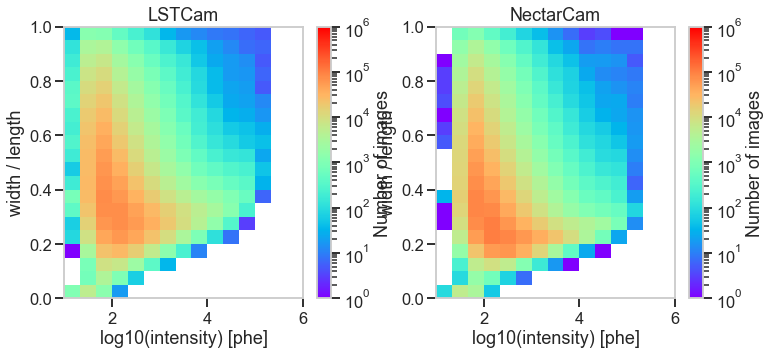

In [13]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.25)

PROTOPIPE_COUNTS = {}

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    intensity = PROTOPIPE_selected[camera]["hillas_intensity"]
    width     = PROTOPIPE_selected[camera]["hillas_width"]
    length    = PROTOPIPE_selected[camera]["hillas_length"]

    PROTOPIPE_COUNTS[camera], _, _, _ = plt.hist2d(x = np.log10(intensity),
                                                   y = width / length,
                                                   bins = [CTAMARS_X_edges, CTAMARS_Y_edges],
                                                   norm = LogNorm(vmin=1.0, vmax=1.e6),
                                                   cmap = "rainbow")
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("Number of images")
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("width / length")
    
    plt.savefig(plots_folder / f"DirectionLUT_counts_{camera}_protopipe_{analysis_name}.png")

plt.show()    

## Counts ratio between protopipe and CTAMARS
[back to top](#Table-of-contents)

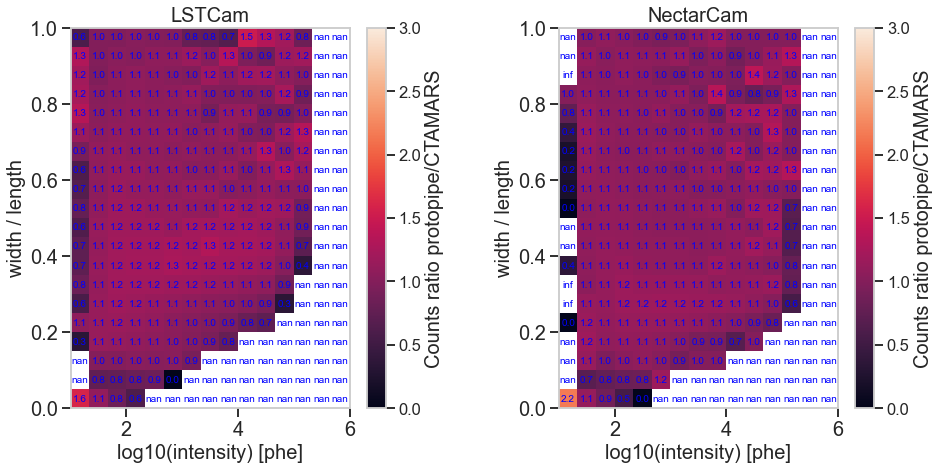

In [14]:
if load_CTAMARS:

    fig = plt.figure(figsize=(15, 7))
    plt.subplots_adjust(wspace = 0.4)
    font_size = 20

    for i, camera in enumerate(cameras):

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            RATIO = PROTOPIPE_COUNTS[camera]/CTAMARS[camera]["DirEventStatistics"].values()

        plt.subplot(1, 2, i+1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            plt.pcolormesh(CTAMARS_X_edges,
                           CTAMARS_Y_edges,
                           np.transpose(PROTOPIPE_COUNTS[camera]/CTAMARS[camera]["DirEventStatistics"].values()),
                           #norm = LogNorm(vmin=1.e-1, vmax=3)
                           vmin=0, vmax=3
                           )

        # add value labels for better visualization
        for i, x in enumerate(CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers()):
            for j, y in enumerate(CTAMARS[camera]["DirLookupTable_degrees"].axes[1].centers()):
                plt.text(x,
                         y,
                         np.round(RATIO[i][j], 1),
                         ha='center',va='center',
                         size=10,color='b')

        plt.title(camera, fontsize=font_size)
        ax = plt.gca()
        cb = plt.colorbar()
        cb.set_label("Counts ratio protopipe/CTAMARS", fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.tick_params(axis='both', which='minor', labelsize=font_size)
        plt.xlabel("log10(intensity) [phe]", fontsize=font_size)
        plt.ylabel("width / length", fontsize=font_size)

        plt.savefig(plots_folder / f"DirectionLUT_counts_ratio_CTAMARS_{camera}_protopipe_{analysis_name}.png")
    plt.show()

else:
    print("CTAMARS reference data not provided.")

## Direction LUT
[back to top](#Table-of-contents)

In [15]:
# Build the LUT by using,

#    - ``np.log10(intensity)`` as ``x`` axis,
#    - ``width/length`` as ``y``axis,

# For each 2D bin we calculate the ``mean of miss`` for the images which fall into that bin.

mean_miss = {}

for camera in cameras:
    
    intensity = PROTOPIPE_selected[camera]["hillas_intensity"]
    width     = PROTOPIPE_selected[camera]["hillas_width"]
    length    = PROTOPIPE_selected[camera]["hillas_length"]
    miss      = PROTOPIPE_selected[camera]["miss"]
    
    mean_miss[camera], _, _, _ = binned_statistic_2d(x = np.log10(intensity), 
                                                     y = width/length, 
                                                     values = miss, 
                                                     statistic='mean', 
                                                     bins=[CTAMARS_X_edges, CTAMARS_Y_edges]
                                                    )

In [16]:
# After obtaining such a 2D binned statistic we square the value of each bin.
# That is the final LUT

LUT = {}

for camera in cameras:
    
    LUT[camera] = np.square(mean_miss[camera])

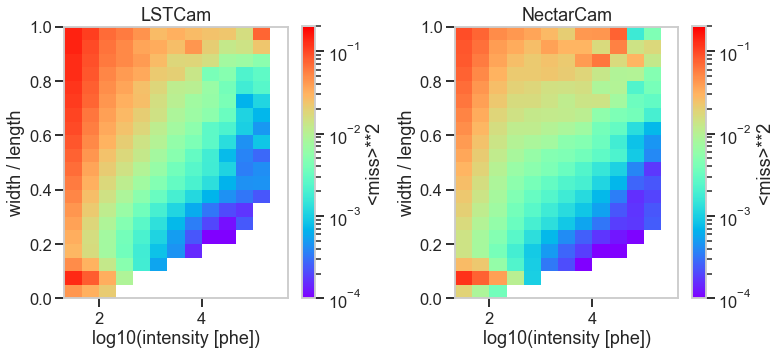

In [17]:
fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace = 0.4)

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)
    
    plt.pcolormesh(CTAMARS_X_edges,
                   CTAMARS_Y_edges,
                   np.transpose( LUT[camera] ),
                   norm = LogNorm(vmin = 1.e-4, vmax = 2.e-1),
                   cmap = "rainbow"
                  )
    
    plt.title(camera)
    cb = plt.colorbar()
    cb.set_label("<miss>**2")
    plt.xlabel("log10(intensity [phe])")
    plt.ylabel("width / length")
    plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-2])
    
    plt.savefig(plots_folder / f"DirectionLUT_{camera}_protopipe_{analysis_name}.png")
plt.show()

## Direction LUT comparisons between protopipe and CTAMARS
[back to top](#Table-of-contents)

### Profile along Y-axis (width/length)
[back to top](#Table-of-contents)

Here we select as an example the bin #9, containing images with 0.45 < width / length < 0.55

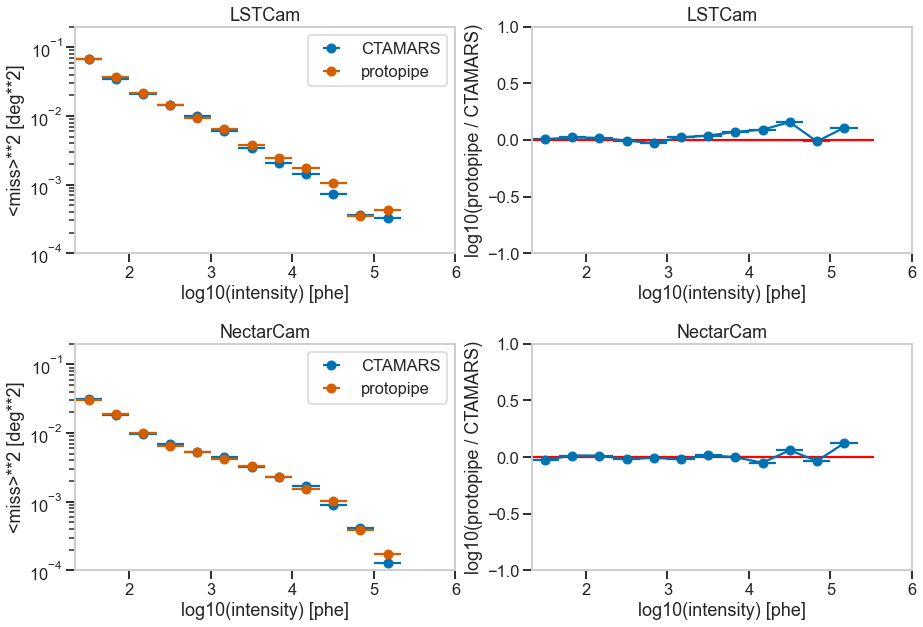

In [18]:
if load_CTAMARS:

    plt.figure(figsize=(15,10))
    h_space = 0.4 if use_seaborn else 0.2
    plt.subplots_adjust(hspace=h_space, wspace=0.2)

    for i, camera in enumerate(cameras):

        plt.subplot(2, 2, i*2+1)

        H = np.transpose(CTAMARS[camera]["DirLookupTable_degrees"].values())

        plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers(),
                     y = H[9],
                     xerr = np.diff(CTAMARS_X_edges)/2,
                     yerr = None,
                     fmt="o",
                     label="CTAMARS")

        plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers(),
                     y = np.transpose(LUT[camera])[9],
                     xerr = np.diff(CTAMARS_X_edges)/2,
                     yerr = None,
                     fmt="o",
                     label="protopipe")

        plt.xlabel("log10(intensity) [phe]")
        plt.ylabel("<miss>**2 [deg**2]")
        plt.grid()
        plt.yscale("log")
        plt.title(camera)
        plt.legend()
        plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-1])
        plt.ylim(1.e-4, 2.e-1)

        plt.subplot(2, 2, i*2+2)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            ratio = np.transpose(LUT[camera])[9] / H[9]
        plt.errorbar(x = CTAMARS[camera]["DirLookupTable_degrees"].axes[0].centers()[1:-1],
                     y = np.log10(ratio[1:-1]),
                     xerr = np.diff(CTAMARS_X_edges[1:-1])/2,
                     yerr = None,
                     ls = "-",
                     fmt="o",)
        plt.hlines(0., plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], colors="red", linestyles='solid')

        plt.xlabel("log10(intensity) [phe]")
        plt.ylabel("log10(protopipe / CTAMARS)")
        plt.grid()
        plt.title(camera)
        plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-1])
        plt.ylim(-1,1.)
        
        plt.savefig(plots_folder / f"DirectionLUT_yProfile_CTAMARS_{camera}_protopipe_{analysis_name}.png")
    plt.show()

else:
    print("CTAMARS reference data not provided.")

### Ratio between the LUTs
[back to top](#Table-of-contents)

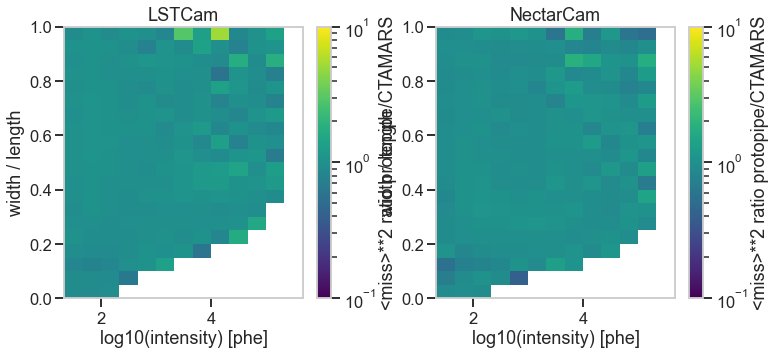

In [19]:
if load_CTAMARS:

    # we use the same bin edges of CTAMARS reference data

    fig = plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace = 0.25)

    for i, camera in enumerate(cameras):

        plt.subplot(1, 2, i+1)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            ratio = LUT[camera] / CTAMARS[camera]["DirLookupTable_degrees"].values()

        plt.pcolormesh(CTAMARS_X_edges,
                       CTAMARS_Y_edges,
                       np.transpose(ratio),
                       norm=LogNorm(vmin=1.e-1, vmax=1.e1),
                       cmap = "viridis"
                       )

        plt.title(camera)
        cb = plt.colorbar()
        cb.set_label("<miss>**2 ratio protopipe/CTAMARS")
        plt.xlabel("log10(intensity) [phe]")
        plt.ylabel("width / length")
        plt.xlim(CTAMARS_X_edges[1], CTAMARS_X_edges[-2])
        
        plt.savefig(plots_folder / f"DirectionLUT_ratio_CTAMARS_{camera}_protopipe_{analysis_name}.png")
    plt.show()

else:
    print("CTAMARS reference data not provided.")

Same, but zomming in the regime of current image quality cuts

- 0.1 < width/length < 0.6
- intensity > 50 phe

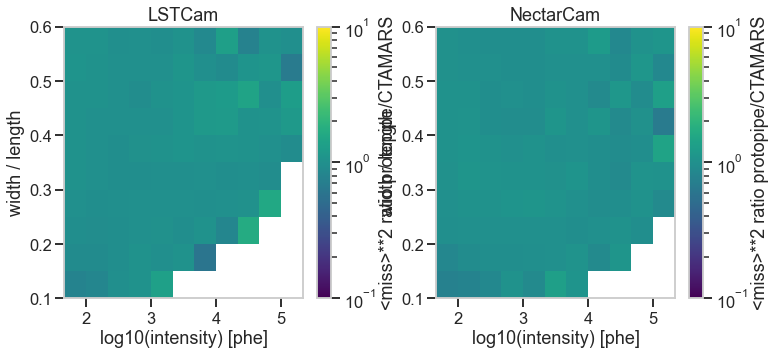

In [20]:
if load_CTAMARS:
    
    fig = plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace = 0.25)

    for i, camera in enumerate(cameras):

        plt.subplot(1, 2, i+1)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            ratio = LUT[camera] / CTAMARS[camera]["DirLookupTable_degrees"].values()

        plt.pcolormesh(CTAMARS_X_edges[2:-2],
                       CTAMARS_Y_edges[2:13],
                       np.transpose(ratio)[2:12,2:-2],
                       norm=LogNorm(vmin=1.e-1, vmax=1.e1),
                       cmap = "viridis"
                       )

        plt.title(camera)
        cb = plt.colorbar()
        cb.set_label("<miss>**2 ratio protopipe/CTAMARS")
        plt.xlabel("log10(intensity) [phe]")
        plt.ylabel("width / length")
        
        plt.savefig(plots_folder / f"DirectionLUT_counts_ratio_zoomed_CTAMARS_{camera}_protopipe_{analysis_name}.png")
    plt.show()

else:
    print("CTAMARS reference data not provided.")